In [9]:
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import relativedelta
pd.set_option('display.max_columns', None)
import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import linregress
import seaborn as sns
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()

import warnings
warnings.filterwarnings("ignore")

loan_data = pd.read_csv('C:\\Users\\ryanc\\Downloads\\loan_data_2007_to_2018.csv\\accepted_2007_to_2018Q4.csv')

<Figure size 640x480 with 0 Axes>

In [6]:
loan_data = loan_data[loan_data['issue_d'].notnull()]
half_count = len(loan_data) / 2
loan_data = loan_data.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values



In [13]:
LoanDf = pd.DataFrame()

In [29]:
for dt in pd.date_range(start='2018-01-31', end='2018-12-31', freq='ME'):
    yr = '2017'
    obs_dt = dt
    mth = pd.to_datetime(obs_dt).strftime('%Y%m')

    loan_data_temp = loan_data[loan_data['issue_d'].astype(str).str.contains(yr)]
    loan_data_temp['obs_dt'] = obs_dt
    loan_data_temp['obs_dt'] = pd.to_datetime(obs_dt, format='%Y-%m-%d')
    
    loan_data_temp['issue_d'] = pd.to_datetime(loan_data_temp['issue_d'],format='%b-%Y')
    loan_data_temp['issue_dt'] = pd.to_datetime(loan_data_temp['issue_d']) + pd.offsets.MonthEnd(0)

    loan_data_temp = loan_data_temp.loc[loan_data_temp['issue_dt']<=obs_dt]

    loan_data_temp['term'] = loan_data_temp['term'].astype(str).str.replace(' months','')
    loan_data_temp['term'] = loan_data_temp['term'].astype(int)
    
    loan_data_temp['mob'] = loan_data_temp['obs_dt'].dt.to_period('M').astype('int64') - \
                            loan_data_temp['issue_dt'].dt.to_period('M').astype('int64')
    
    loan_data_temp['last_pymnt_d'] = pd.to_datetime(loan_data_temp['last_pymnt_d'],format='%b-%Y')
    loan_data_temp['last_pymt_dt'] = pd.to_datetime(loan_data_temp['last_pymnt_d']) + pd.offsets.MonthEnd(0)
    loan_data_temp['last_pymt_dt'] = np.where(loan_data_temp['last_pymt_dt'] <= loan_data_temp['obs_dt'],loan_data_temp['last_pymt_dt'],loan_data_temp['obs_dt'])

    loan_data_temp['mths_paid'] = loan_data_temp['last_pymt_dt'].dt.to_period('M').astype('int64') - \
                                  loan_data_temp['issue_dt'].dt.to_period('M').astype('int64')

    loan_data_temp['mths_odue'] = loan_data_temp['obs_dt'].dt.to_period('M').astype('int64') - \
                                  loan_data_temp['last_pymt_dt'].dt.to_period('M').astype('int64')
    
    loan_data_temp['mths_unpaid'] = np.where(loan_data_temp['last_pymt_dt']<=loan_data_temp['issue_dt'],loan_data_temp['term'] - loan_data_temp['mths_paid'],0)
    
    loan_data_temp['amt_unpaid'] = loan_data_temp['installment'] * loan_data_temp['mths_unpaid']

    loan_data_temp['mature_dt'] = loan_data_temp.apply(lambda x: x['issue_dt'] + pd.DateOffset(months=x['term']), axis=1)

    def odue_bucket(x):
        if x['mths_odue'] == 0:
            return 'M0'
        elif x['mths_odue'] == 1:
            return 'M1'
        elif x['mths_odue'] == 2:
            return 'M2'
        elif x['mths_odue'] == 3:
            return 'M3'    
        elif x['mths_odue'] >= 4:
            return 'M4+'
    loan_data_temp['odue_bucket'] = loan_data_temp.apply(odue_bucket, axis=1)
    
    loan_data_temp['odue_amt'] = loan_data_temp['mths_odue'] * loan_data_temp['installment']
    loan_data_temp['M1_amt'] = np.where(loan_data_temp['odue_bucket']=='M1',loan_data_temp['odue_amt'],0)
    loan_data_temp['M2_amt'] = np.where(loan_data_temp['odue_bucket']=='M2',loan_data_temp['odue_amt'],0)
    loan_data_temp['M3_amt'] = np.where(loan_data_temp['odue_bucket']=='M3',loan_data_temp['odue_amt'],0)
    loan_data_temp['M4_amt'] = np.where(loan_data_temp['odue_bucket']=='M4+',loan_data_temp['odue_amt'],0)

    print('# Aggregating loan data as of',dt,'is completed. Rows ct:',len(loan_data_temp))
    LoanDf = pd.concat([LoanDf,loan_data_temp])
    print('# Concat loan data as of',dt,'is completed. Rows ct:',len(LoanDf))


# Aggregating loan data as of 2018-01-31 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-01-31 00:00:00 is completed. Rows ct: 3188506
# Aggregating loan data as of 2018-02-28 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-02-28 00:00:00 is completed. Rows ct: 3632085
# Aggregating loan data as of 2018-03-31 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-03-31 00:00:00 is completed. Rows ct: 4075664
# Aggregating loan data as of 2018-04-30 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-04-30 00:00:00 is completed. Rows ct: 4519243
# Aggregating loan data as of 2018-05-31 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-05-31 00:00:00 is completed. Rows ct: 4962822
# Aggregating loan data as of 2018-06-30 00:00:00 is completed. Rows ct: 443579
# Concat loan data as of 2018-06-30 00:00:00 is completed. Rows ct: 5406401
# Aggregating loan data as of 2018-07-31 00:00:00 is completed. 

In [31]:
df_mob = pd.pivot_table(LoanDf,index='issue_dt',columns='mob',values='M1_amt',aggfunc='sum')

In [33]:
df_loan = LoanDf.groupby(['issue_dt'])['amt_unpaid'].sum().round()
df_loan

issue_dt
2017-01-31    701139822.0
2017-02-28    604706159.0
2017-03-31    805187378.0
2017-04-30    631270307.0
2017-05-31    793857034.0
2017-06-30    794253543.0
2017-07-31    830274692.0
2017-08-31    886120017.0
2017-09-30    864241534.0
2017-10-31    807066242.0
2017-11-30    892399339.0
2017-12-31    825497268.0
Name: amt_unpaid, dtype: float64

In [35]:
df_mob_all = pd.concat([df_loan,df_mob],axis=1)
df_mob_all

,amt_unpaid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
issue_dt,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,701139822.0,0.0,88573.79,207896.48,243290.02,216723.59,274856.36,283367.59,282828.22,355304.79,311482.05,345756.72,314182.84,297706.03,336871.61,306701.12,403773.56,310734.64,314502.85,328054.85,311241.02,334083.52,250698.43,301803.86,265892.53
2017-02-28,604706159.0,0.0,62439.62,228681.99,145820.56,188437.59,212228.30,224059.90,293197.63,242396.30,274089.16,259263.39,219733.22,306591.13,254724.85,329633.83,300538.97,283167.68,277448.40,295570.45,324908.38,232975.76,270230.10,249940.08,NaN
2017-03-31,805187378.0,0.0,104787.61,220252.58,227159.05,280068.56,308350.47,308086.04,317557.95,352711.87,328084.10,302803.44,355993.63,363041.74,404815.69,353286.16,411064.36,354217.33,400408.09,417619.40,272940.68,305027.12,329256.77,NaN,NaN
2017-04-30,631270307.0,0.0,66667.88,215277.29,177234.00,215770.90,260016.41,226406.11,282387.59,279624.27,225536.90,296804.51,213372.48,344358.75,282191.79,314487.98,317003.74,323288.49,323231.45,238927.09,253482.87,252234.49,NaN,NaN,NaN
2017-05-31,793857034.0,0.0,99345.42,250292.02,228986.52,279474.92,277865.65,306158.54,330152.42,334296.41,342717.20,290863.79,418344.23,347401.73,384293.18,415743.18,405299.00,443946.43,350029.02,359140.91,289698.70,NaN,NaN,NaN,NaN
2017-06-30,794253543.0,0.0,93899.39,231642.23,227188.03,259562.57,298152.99,293125.44,286178.09,353957.66,308810.52,412618.97,338821.88,384128.28,374877.78,421005.52,446735.28,337707.75,357204.89,321047.82,NaN,NaN,NaN,NaN,NaN
2017-07-31,830274692.0,0.0,112014.95,262095.48,196880.71,256739.19,310090.77,298523.62,333202.60,276526.94,434956.61,347431.11,358021.11,397524.62,421019.12,454521.64,356330.18,378428.45,345538.81,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,886120017.0,0.0,116115.24,243323.19,220334.68,271927.01,266043.30,326877.23,339045.63,438121.96,370775.45,433391.60,410241.85,446307.92,479091.02,419203.42,453848.85,370893.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30,864241534.0,0.0,94647.47,255825.90,227952.34,247939.61,309605.66,284839.21,405555.52,355595.01,376771.68,412561.21,389969.40,459373.78,389953.94,440117.91,423006.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_mob_rate = (df_mob_all.divide(df_mob_all['amt_unpaid'],axis=0)*100).round(3)
df_mob_rate

,amt_unpaid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
issue_dt,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,100.0,0.0,0.013,0.030,0.035,0.031,0.039,0.040,0.040,0.051,0.044,0.049,0.045,0.042,0.048,0.044,0.058,0.044,0.045,0.047,0.044,0.048,0.036,0.043,0.038
2017-02-28,100.0,0.0,0.010,0.038,0.024,0.031,0.035,0.037,0.048,0.040,0.045,0.043,0.036,0.051,0.042,0.055,0.050,0.047,0.046,0.049,0.054,0.039,0.045,0.041,NaN
2017-03-31,100.0,0.0,0.013,0.027,0.028,0.035,0.038,0.038,0.039,0.044,0.041,0.038,0.044,0.045,0.050,0.044,0.051,0.044,0.050,0.052,0.034,0.038,0.041,NaN,NaN
2017-04-30,100.0,0.0,0.011,0.034,0.028,0.034,0.041,0.036,0.045,0.044,0.036,0.047,0.034,0.055,0.045,0.050,0.050,0.051,0.051,0.038,0.040,0.040,NaN,NaN,NaN
2017-05-31,100.0,0.0,0.013,0.032,0.029,0.035,0.035,0.039,0.042,0.042,0.043,0.037,0.053,0.044,0.048,0.052,0.051,0.056,0.044,0.045,0.036,NaN,NaN,NaN,NaN
2017-06-30,100.0,0.0,0.012,0.029,0.029,0.033,0.038,0.037,0.036,0.045,0.039,0.052,0.043,0.048,0.047,0.053,0.056,0.043,0.045,0.040,NaN,NaN,NaN,NaN,NaN
2017-07-31,100.0,0.0,0.013,0.032,0.024,0.031,0.037,0.036,0.040,0.033,0.052,0.042,0.043,0.048,0.051,0.055,0.043,0.046,0.042,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,100.0,0.0,0.013,0.027,0.025,0.031,0.030,0.037,0.038,0.049,0.042,0.049,0.046,0.050,0.054,0.047,0.051,0.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30,100.0,0.0,0.011,0.030,0.026,0.029,0.036,0.033,0.047,0.041,0.044,0.048,0.045,0.053,0.045,0.051,0.049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


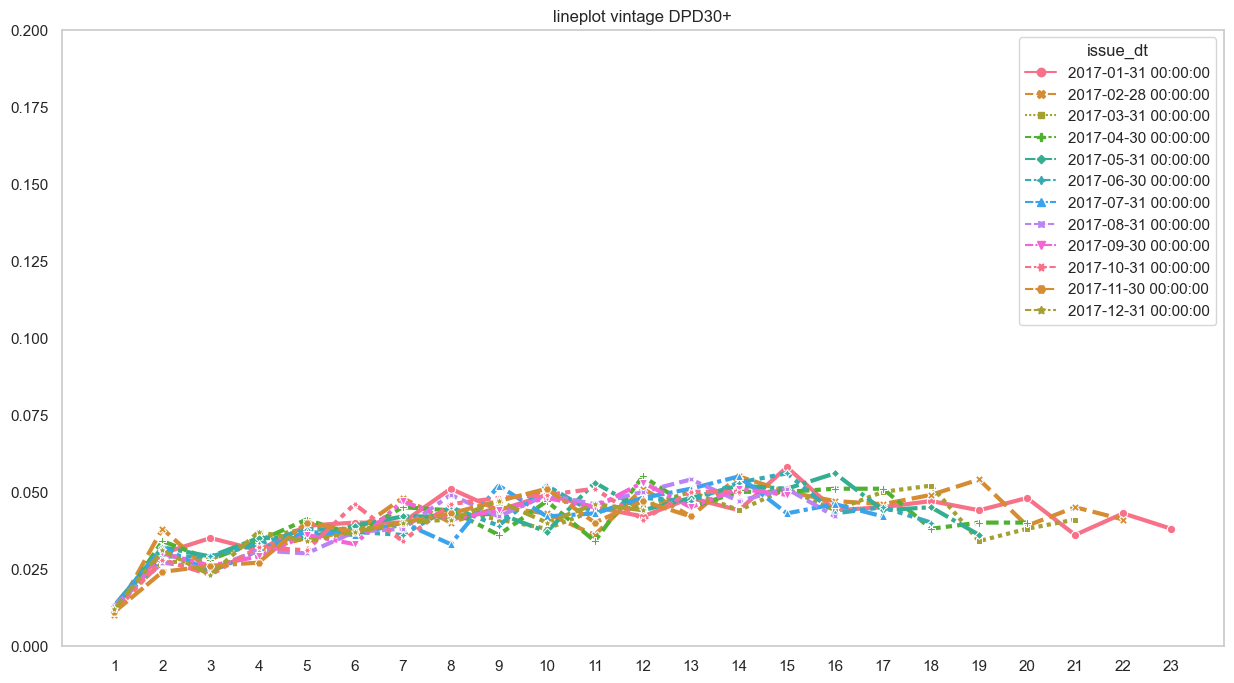

In [39]:
palette = sns.color_palette("husl", 9)
plt.figure(figsize=(15, 8))
plt.title('lineplot vintage DPD30+')
plt.ylim(0,0.2)
plt.xticks(df_mob_rate.loc[:,1:].columns.tolist())
sns.lineplot(data=df_mob_rate.loc[:,1:].T, markers=True, dashes=True, lw=3, palette=palette)
plt.show()
